In [1]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import zipfile

import math

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import listdir
import h5py as h5
import os
import time
import multiprocessing
from tqdm import tqdm
import time
from PIL import Image
from matplotlib import gridspec
from gwpy.signal import filter_design
from torch import optim
from scipy.stats import pearsonr
import librosa

In [3]:
try:
    import gwpy
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError:
    !pip install --quiet gwpy
    import gwpy
    from gwpy.timeseries import TimeSeries

In [4]:
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    device = 'cpu'

NVIDIA A100-PCIE-40GB


In [5]:
def generate_dataset_timeseries(rows, columns, duration=10, sample_rate=500, num_waves_range=(10, 15), noise_amplitude=0.1):
    """
    Generate a Pandas DataFrame with randomly generated smooth sine wave time series with added smooth random noise.
    
    Parameters:
        - rows (int): Number of rows in the DataFrame.
        - columns (int): Number of columns in the DataFrame.
        - duration (float): Duration of the time series data in seconds (default is 6 seconds).
        - sample_rate (int): Sampling rate of the time series data in samples per second (default is 500 samples per second).
        - num_waves_range (tuple): Range for the random number of sine waves to be generated for each time series.
                                   Format: (min_num_waves, max_num_waves) (default is (10, 15)).
        - noise_amplitude (float): Amplitude of the smooth random noise added to the time series data (default is 0.1).
    
    Returns:
        - DataFrame: Pandas DataFrame containing the generated time series data.
    """
  
   
    
    # Initialize an empty list to store individual DataFrames for each row
    dfs = []
    columns_list= [f'Channel_{i+1}' for i in range(columns)]
    
    # Generate time array
    times = np.linspace(0, duration, duration * sample_rate)
    
    mu = duration /2
    sigma = duration /4
    
    frequency0 = 3
    
    #*
    
    for index in range(rows):
        df_dict={}
        for col in range(columns):
            # Initialize an array to store the generated wave data for this row
            wave_data = np.zeros(len(times))
            # Determine the number of sine waves to generate for this column randomly
            num_waves = np.random.randint(*num_waves_range)
            
            # Generate each sine wave
            for _ in range(num_waves):
                           
      
    
                #sigma = duration /np.random.uniform(1, 10)  # Standard deviation for the Gaussian
                  # Standard deviation for the Gaussian

                #mu = duration /np.random.uniform(0.1, 5)     # Mean (center) of the Gaussian
                     # Mean (center) of the Gaussian

                # Gaussian envelope
                #envelope = np.exp(-0.5 * ((times - mu) / sigma) ** 2)
                #frequency0 = np.random.uniform(1, 5)
                envelope=np.sin(2 * np.pi * frequency0 * times)*np.exp(-0.5 * ((times - mu) / sigma) ** 2)
                
                
                # Randomly generate parameters for the sine wave (amplitude, frequency, phase)
                amplitude = np.random.uniform(0.5, 2.0)
                #frequency = np.random.uniform(90, 130)
                frequency = np.random.uniform(0.1, 5)
                #frequency=0.2
                #frequency0 = np.random.uniform(0.1, 2)
                #frequency=frequency0*times**1.5
                phase = np.random.uniform(0, 2*np.pi)
                
                # Generate the sine wave and add it to the wave_data
                wave_data += envelope* np.sin(2 * np.pi * frequency * times + phase)
                #wave_data += amplitude * np.sin(2 * np.pi * frequency * times + phase)

                
            
            # Add smooth random noise to the wave data
            smooth_noise = np.random.normal(0, noise_amplitude, len(times))
            wave_data += smooth_noise
            wave_data=wave_data/max(wave_data)
        
            # Create a TimeSeries object from the wave data
            ts = TimeSeries(wave_data, t0=0, dt=1/sample_rate)
            df_dict[f'Channel_{col+1}']=[ts]
            
        #Create a DataFrame with the TimeSeries
        df_row = pd.DataFrame(df_dict)
        
        # Append the DataFrame to the list
        dfs.append(df_row)
    
    # Concatenate the list of DataFrames into a single DataFrame along rows axis
    df = pd.concat(dfs, ignore_index=True, axis=0)
    
    return df

In [ ]:
df_tms=generate_dataset_timeseries(10000, 1, duration=10, sample_rate=512, num_waves_range=(1,2), noise_amplitude=0.1)
df_qts=df_tms.apply(lambda x: x[0].q_transform(qrange=(5,5),frange=(5,15)), axis=1)

In [ ]:
df_tms.to_pickle('DF_Training_SpecInv_TimeSeries_10000.pkl')
df_qts.to_pickle('DF_Training_SpecInv_Spectrograms_10000.pkl')                 

In [14]:
df_tms=pd.read_pickle('DF_Training_SpecInv_TimeSeries_10000.pkl')
df_qts=pd.read_pickle('DF_Training_SpecInv_Spectrograms_10000.pkl') 

In [15]:
tensor_list=[]
for index, row in df_tms.iterrows():
    # Extract the TimeSeries object
    timeseries = row['Channel_1']
    
    # Convert TimeSeries to numpy array
    timeseries_array = timeseries.value  # .value gives the numpy array of TimeSeries data
    
    # Convert numpy array to PyTorch tensor
    timeseries_tensor = torch.tensor(timeseries_array, dtype=torch.float64)
    
    # Append tensor to the list
    tensor_list.append(timeseries_tensor)

# If needed, you can stack these tensors into a single tensor
# This will create a 2D tensor where each row corresponds to one TimeSeries
y_train_tensor = torch.stack(tensor_list)

In [16]:
X_train_tensor=df_qts.apply(lambda x: torch.tensor(x,dtype=torch.float64))
#y_train_tensor = torch.tensor(df_tms.apply(lambda x: np.array(x[0]), axis=1),dtype=torch.float32)

In [17]:
X_train_tensor=torch.stack(list(X_train_tensor))

In [9]:
#Only run this cell if you are using the CNN or the ResNet

N, H, W= X_train_tensor.shape
X_train_tensor = X_train_tensor.view(N, 1, H, W)

In [ ]:
df_test_tms=generate_dataset_timeseries(1000, 1, duration=10, sample_rate=512, num_waves_range=(1,2), noise_amplitude=0.1)
df_test_qts=df_test_tms.apply(lambda x: x[0].q_transform(qrange=(5,5),frange=(5,15)), axis=1)

In [ ]:
df_test_tms.to_pickle('DF_Test_SpecInv_TimeSeries_1000.pkl')
df_test_qts.to_pickle('DF_Test_SpecInv_Spectrograms_1000.pkl')      

In [12]:
df_test_tms=pd.read_pickle('DF_Test_SpecInv_TimeSeries_1000.pkl')
df_test_qts=pd.read_pickle('DF_Test_SpecInv_Spectrograms_1000.pkl') 

Print some test timeseries

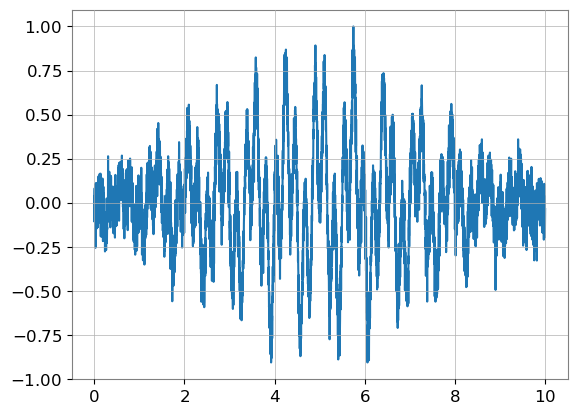

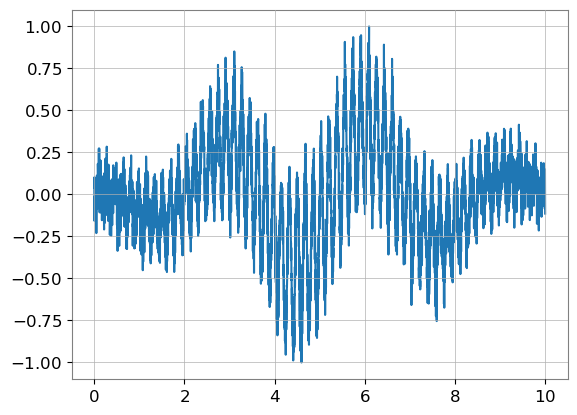

In [13]:
for i in range(2):
    plt.plot(df_test_tms.iloc[i][0])
    plt.show()

In [18]:
tensor_test_list=[]
for index, row in df_test_tms.iterrows():
    # Extract the TimeSeries object
    timeseries = row['Channel_1']
    
    # Convert TimeSeries to numpy array
    timeseries_array = timeseries.value  # .value gives the numpy array of TimeSeries data
    
    # Convert numpy array to PyTorch tensor
    timeseries_tensor = torch.tensor(timeseries_array, dtype=torch.float64)
    
    # Append tensor to the list
    tensor_test_list.append(timeseries_tensor)

# If needed, you can stack these tensors into a single tensor
# This will create a 2D tensor where each row corresponds to one TimeSeries
y_test_tensor = torch.stack(tensor_test_list)

In [19]:
X_test_tensor=df_test_qts.apply(lambda x: torch.tensor(x,dtype=torch.float64))
X_test_tensor=torch.stack(list(X_test_tensor))

Only run the cell below if you are using the CNN or the ResNet

In [ ]:
N, H, W=X_test_tensor.shape
X_test_tensor = X_test_tensor.view(N, 1, H, W)

# Models

## ResNet

In [ ]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=5120):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(ResidualBlock, [2, 2, 2, 2])

# Example usage
# Assuming you have your spectrogram data stored in X_train and time series data stored in y_train

# Preprocess spectrogram data if needed
# Preprocess time series data if needed

# Convert data to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Create ResNet model
model = ResNet18()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import os
import pickle

class CNNLSTM(nn.Module):
    def __init__(self, input_channels=1, num_classes=5000, lstm_hidden_size=512):
        super(CNNLSTM, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.lstm_input_size = 128 * (1000 // 2 // 2)  # Considering the pooling layers
        self.lstm_hidden_size = lstm_hidden_size  # Set the hidden layer size
        self.lstm = nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, batch_first=True)
        self.fc = nn.Linear(self.lstm_hidden_size, num_classes)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        if torch.isnan(x).any():
            print(f'After conv1: {x}')
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        if torch.isnan(x).any():
            print(f'After conv2: {x}')
        
        batch_size, _, _, _ = x.size()
        x = x.view(batch_size, -1, self.lstm_input_size)
        if torch.isnan(x).any():
            print(f'After view: {x}')
        
        x, _ = self.lstm(x)
        if torch.isnan(x).any():
            print(f'After LSTM: {x}')
        
        x = self.fc(x[:, -1, :])
        if torch.isnan(x).any():
            print(f'After FC: {x}')
        
        return x

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

model = CNNLSTM(input_channels=1, num_classes=5120, lstm_hidden_size=1024)
model.apply(weights_init)
model = model.double()  # Convert model parameters to float64

Testing the generation with random initialisation

In [ ]:
for i in range(3):
    tms_real=TimeSeries(df_tms.iloc[i][0], dt=1/500)
    #qplot_test=tms_real.q_transform(qrange=(12,12),frange=(5,15))
    spectrogram_test=torch.tensor(df_qts.iloc[i], dtype=torch.float64)
    H, W= spectrogram_test.shape
    spectrogram_test = spectrogram_test.view(1, 1, H, W)
    model.eval()
    with torch.no_grad():
        output = model(spectrogram_test)
    tms_generated=TimeSeries(output[0], dt=1/500)

    plt.figure(figsize=(14, 7))
    plt.plot(tms_real, label='Original TimeSeries')
    plt.plot(tms_generated, label='Generated Output', linestyle='--')
    plt.title("Comparison of Original TimeSeries and Model Generated Output")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

# Loss Function

In [ ]:
import torch.fft as fft

class CombinedLossWithCorrelation(nn.Module):
    def __init__(self, alpha=1.0, beta=0.1, gamma=0.1, delta=0.1):
        super(CombinedLossWithCorrelation, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.mae = nn.L1Loss()

    def forward(self, predictions, targets):
        # Mean Absolute Error (MAE) Loss
        mae_loss = self.mae(predictions, targets)

        # Frequency Domain Loss (using FFT)
        pred_fft = fft.fft(predictions)
        target_fft = fft.fft(targets)
        freq_loss = self.mae(torch.abs(pred_fft), torch.abs(target_fft))

        # Total Vafriation Loss
        tv_loss = torch.mean(torch.abs(predictions[:, :-1] - predictions[:, 1:]))

        # Pearson Correlation Loss
        predictions_centered = predictions - torch.mean(predictions, dim=1, keepdim=True)
        targets_centered = targets - torch.mean(targets, dim=1, keepdim=True)
        correlation = torch.sum(predictions_centered * targets_centered, dim=1) / (
            torch.sqrt(torch.sum(predictions_centered ** 2, dim=1)) * torch.sqrt(torch.sum(targets_centered ** 2, dim=1))
        )
        correlation_loss = -torch.mean(correlation)  # Negative because we want to maximize correlation

        # Combined Loss
        loss = self.alpha * mae_loss + self.beta * freq_loss + self.gamma * tv_loss + self.delta * correlation_loss
        return loss

# Example usage
loss_function = CombinedLossWithCorrelation(alpha=1.0, beta=0.1, gamma=0.1, delta=0.1)

In [ ]:
# Define a custom loss function
class CustomLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=0.1, gamma=0.1, delta=0.1, epsilon=0.1):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.epsilon = epsilon
        self.mae = nn.L1Loss()
    
    def forward(self, predictions, targets):
        # Mean Absolute Error (MAE) Loss
        mae_loss = self.mae(predictions, targets)
        
        # Frequency Domain Loss (using FFT)
        pred_fft = torch.fft.fft(predictions)
        target_fft = torch.fft.fft(targets)
        freq_loss = self.mae(torch.abs(pred_fft), torch.abs(target_fft))
        
        # Total Variation Loss
        tv_loss = torch.mean(torch.abs(predictions[:, :-1] - predictions[:, 1:]))
        
        # Pearson Correlation Loss
        predictions_centered = predictions - torch.mean(predictions, dim=1, keepdim=True)
        targets_centered = targets - torch.mean(targets, dim=1, keepdim=True)
        correlation = torch.sum(predictions_centered * targets_centered, dim=1) / (
            torch.sqrt(torch.sum(predictions_centered ** 2, dim=1)) * torch.sqrt(torch.sum(targets_centered ** 2, dim=1))
        )
        correlation_loss = -torch.mean(correlation)  # Negative because we want to maximize correlation
        
        # Variability Penalty
        variability_penalty = self.epsilon * torch.mean(torch.abs(predictions[:, 1:] - predictions[:, :-1]))
        
        # Combined Loss
        loss = self.alpha * mae_loss + self.beta * freq_loss + self.gamma * tv_loss + self.delta * correlation_loss + variability_penalty
        return loss

In [ ]:
def get_magnitude(stft_res):
    real = stft_res[:, :, :, 0]
    im = stft_res[:, :, :, 1]
    return torch.sqrt(torch.pow(real, 2) + torch.pow(im, 2))
def compute_stft(x):
    _window = torch.hann_window(1024)
    stft = torch.stft(x, 1024, win_length=1024, hop_length=64, window=_window, center=False, normalized=True,return_complex=False).cuda().transpose(1,2)
    stft /= _window.pow(2).sum().sqrt()
    return get_magnitude(stft)

In [ ]:
def compute_loss(y, target):
    b = y.shape[0]
  
    stft_y = compute_stft(y).reshape(b, -1)
    
        
    stft_target = compute_stft(target).reshape(b, -1)

    p1 = torch.norm(stft_target - stft_y, p=2, dim=1)

    p2 = torch.norm(stft_target, p=2, dim=1)

    sc_loss = torch.mean(p1/(p2+1e-19))

    return sc_loss

# Training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
from scipy.stats import pearsonr

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

train_losses = []
val_losses = []
val_pearson_correlations = []

patience = 5
best_val_loss = float('inf')
patience_counter = 0
num_epochs = 50

# Variables to store previous epoch's inputs and targets
prev_epoch_inputs = None
prev_epoch_targets = None

nan_encountered = False

for epoch in range(num_epochs):
    if nan_encountered:
        break

    model.train()
    running_train_loss = 0.0
    running_val_pearson = 0.0
    num_val_samples = 0
    
    # Store current epoch's inputs and targets
    epoch_inputs = []
    epoch_targets = []

    for inputs, targets in train_loader:
        if torch.isnan(inputs).any() or torch.isinf(inputs).any():
            print("NaN or Inf found in input data")
            continue
        
        optimizer.zero_grad()
        outputs = model(inputs)
        if torch.isnan(outputs).any():
            # Save previous epoch's inputs and targets if NaNs are encountered
            if prev_epoch_inputs is not None and prev_epoch_targets is not None:
                with open('prev_epoch_inputs.pkl', 'wb') as f:
                    pickle.dump(prev_epoch_inputs, f)
                with open('prev_epoch_targets.pkl', 'wb') as f:
                    pickle.dump(prev_epoch_targets, f)
                print('NAN ENCOUNTERED, saved previous epoch inputs and targets')
            torch.save(model.state_dict(), 'nan_model.pth')
            nan_encountered = True
            break
        
        loss = compute_loss(outputs, targets)
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            print("NaN or Inf found in loss")
            continue
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_train_loss += loss.item()

        # Store inputs and targets for the current batch
        epoch_inputs.append(inputs.cpu().numpy())
        epoch_targets.append(targets.cpu().numpy())
    
    if nan_encountered:
        break
    
    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = compute_loss(outputs, targets)
            running_val_loss += loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)

    
    # Convert outputs and targets to numpy arrays for Pearson correlation calculation
    outputs_np = outputs.detach().numpy()
    targets_np = targets.detach().numpy()
    for out, target in zip(outputs_np, targets_np):
        pearson_corr, _ = pearsonr(out, target)
        running_val_pearson += pearson_corr
        num_val_samples += 1
    
    val_pearson_correlations.append(abs(running_val_pearson)/num_val_samples)
    
    scheduler.step(avg_val_loss) 
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break
    
    # Update previous epoch's inputs and targets
    prev_epoch_inputs = epoch_inputs
    prev_epoch_targets = epoch_targets

if nan_encountered:
    print("Training stopped due to NaN in outputs.")

    fig=plt.figure(figsize=(14, 7))
gs=gridspec.GridSpec(2,1)
ax1 = plt.subplot(gs[0,0])

# Plot the training and validation metrics
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')

ax2 = plt.subplot(gs[1,0])
ax2.plot(val_pearson_correlations, label='Validation Pearson')

plt.show()

# MCNN

In [20]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd

import numpy as np
import torch
#from utils import *
%matplotlib inline

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare DataLoader for training and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [23]:
DEFAULT_LAYERS_PARAMS = [
 (2, 16, 128, 0),
 (2, 16, 64, 0),
 (2, 16, 32, 0),
 (2, 16, 16, 0),
 (2, 16, 8, 0),
 (2, 16, 4, 0),
 (2, 16, 2, 0),
 (2, 16, 1, 0)]

In [ ]:
# class MCNN(nn.Module):
#     def __init__(self, n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS,output_size=5000):
#         super(MCNN, self).__init__()
#         self._heads = nn.ModuleList()
#         for i in range(n_heads):
#             h = self._create_head(layer_params)
#             self._heads.append(h)
            
            
#         in_channels = 1000
#         seq_length = 20  # initial sequence length
#         for stride, kernel_size, out_channels, _ in layer_params:
#             seq_length = (seq_length - 1) * stride + kernel_size
#             in_channels = out_channels
#         print(seq_length)
#         self.flattened_size = seq_length * out_channels
#         print(self.flattened_size)
#         #self.linear = nn.Linear(self.flattened_size * n_heads, output_size)
#         self.linear = nn.Linear(n_heads, output_size)

        
        
#         #self.linear = nn.Linear(n_heads, 1)
#         self.act_fn = nn.Softsign()
    
#     def forward(self, x):
# #         import pdb; pdb.set_trace();
#         b = x.shape[0]
#         #print([head for head in self._heads])
#         out = [head(x).reshape(-1, 1) for head in self._heads]
#         out = torch.cat(out, dim=1)
#         print(self.flattened_size)
#         out = self.linear(out)
#         out = self.act_fn(out).reshape(b, -1)
#         return out
        
#     def _create_head(self, layer_params):
#         layers = []
#         for i, p in enumerate(layer_params):
#             stride, kernel_size, out_channels, add = p        
#             if i == 0:
#                 in_channels = 1000
#             else:
#                 in_channels = layer_params[i-1][2]
              
#             padding = (kernel_size - stride)//2
#             m = torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size + add, stride=stride, padding=padding)
#             layers.append(m)
#             layers.append(nn.ELU())
            
#         return nn.Sequential(*layers).cuda()

In [ ]:
class MCNN(nn.Module):
    def __init__(self, n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS):
        super(MCNN, self).__init__()
        self._heads = nn.ModuleList()
        for i in range(n_heads):
            h = self._create_head(layer_params)
            self._heads.append(h)
        self.linear = nn.Linear(n_heads, 1)
        self.act_fn = nn.Softsign()
    
    def forward(self, x):
#         import pdb; pdb.set_trace();
        b = x.shape[0]
        out = [head(x).reshape(-1, 1) for head in self._heads]
        out = torch.cat(out, dim=1)
        out = self.linear(out)
        out = self.act_fn(out).reshape(b, -1)
        return out
        
    def _create_head(self, layer_params):
        layers = []
        for i, p in enumerate(layer_params):
            stride, kernel_size, out_channels, add = p
            if i == 0:
                in_channels = 1000
            else:
                in_channels = layer_params[i-1][2]
            padding = (kernel_size - stride)//2
            m = torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size + add, stride=stride, padding=padding)
            layers.append(m)
            layers.append(nn.ELU())
            
        return nn.Sequential(*layers).cuda()

In [24]:
class MCNN(nn.Module):
    def __init__(self, n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS):
        super(MCNN, self).__init__()
        self._heads = nn.ModuleList()
        for i in range(n_heads):
            h = self._create_head(layer_params)
            self._heads.append(h)
        self.linear = nn.Linear(n_heads, 1)
        self.act_fn = nn.Softsign()
    
    def forward(self, x):
        b = x.shape[0]
        out = []
        for head in self._heads:
            h_out = head(x).reshape(-1, 1)
            if torch.isnan(h_out).any():
                print('H_OUT = '+str(h_out))
                raise ValueError(f'NaN detected in head output')
            out.append(h_out)
        
        out = torch.cat(out, dim=1)
        if torch.isnan(out).any():
            raise ValueError('NaN detected after concatenation')
        
        out = self.linear(out)
        if torch.isnan(out).any():
            raise ValueError('NaN detected after linear layer')
        
        out = self.act_fn(out).reshape(b, -1)
        if torch.isnan(out).any():
            raise ValueError('NaN detected after activation function')
        
        return out
        
    def _create_head(self, layer_params):
        layers = []
        for i, p in enumerate(layer_params):
            stride, kernel_size, out_channels, add = p
            if i == 0:
                in_channels = 1000  # Adjust this if your input channels are different
            else:
                in_channels = layer_params[i-1][2]
            padding = (kernel_size - stride) // 2
            m = nn.ConvTranspose1d(in_channels, out_channels, kernel_size + add, stride=stride, padding=padding)
            layers.append(m)
            layers.append(nn.ELU())
            
        return nn.Sequential(*layers).cuda()

In [25]:
def get_magnitude(stft_res):
    real = stft_res[:, :, :, 0]
    im = stft_res[:, :, :, 1]
    return torch.sqrt(torch.pow(real, 2) + torch.pow(im, 2))
def compute_stft(x):
    _window = torch.hann_window(1024).cuda()
    stft = torch.stft(x, 1024, win_length=1024, hop_length=64, window=_window, center=False, normalized=True,return_complex=False).cuda().transpose(1,2)
    stft /= _window.pow(2).sum().sqrt()
    return get_magnitude(stft)

In [26]:
def compute_loss(y, target):
    b = y.shape[0]
    if math.isnan(b):
        print('DEBUG0')
    stft_y = compute_stft(y).reshape(b, -1)
    if torch.isnan(stft_y).any():
        print('DEBUG1')
        print(y)
        
    stft_target = compute_stft(target).reshape(b, -1)
    if torch.isnan(stft_target).any():
        print('DEBUG2')
        print(target)
    p1 = torch.norm(stft_target - stft_y, p=2, dim=1)

    p2 = torch.norm(stft_target, p=2, dim=1)

    sc_loss = torch.mean(p1/(p2+1e-19))

    return sc_loss

In [ ]:
# Create the model instance
#model = MCNN(n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS).cuda()
#model = MCNN(n_heads=3, layer_params=DEFAULT_LAYERS_PARAMS).cuda()
#, output_size=5000
# Sample input tensor with shape [10, 1000, 20]
#mock_inputs = torch.randn(10, 1000, 20).cuda()
#targets=torch.randn(10,5120).cuda() 

# Evaluate the model
#mock_outputs = model(mock_inputs)
#print(mock_outputs)
#targets=targets.cuda()
#loss = compute_loss(mock_outputs, targets)

In [27]:
def plot_grad_histograms(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            plt.figure()
            plt.hist(param.grad.cpu().numpy().flatten(), bins=100)
            plt.title(f"Gradient Histogram for {name}")
            plt.xlabel("Gradient value")
            plt.ylabel("Frequency")
            plt.show()

def print_grad_stats(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad = param.grad
            print(f"Layer: {name}")
            print(f"  Mean: {grad.mean().item()}")
            print(f"  Max: {grad.max().item()}")
            print(f"  Min: {grad.min().item()}")
            print(f"  Std: {grad.std().item()}\n")
        else:
            print(f"Layer: {name} has no gradients")
            

def pearson_correlation(x, y):
    # Function to compute Pearson correlation coefficient
    return np.corrcoef(x, y)[0, 1]

In [ ]:
def train(model, optimizer, train_loader, valid_loader, device='cuda', max_epochs=100, patience=5, min_delta=0.001):
    # Early stopping parameters
    best_valid_loss = float('inf')
    current_patience = 0
    best_model_state = None

    train_loss_list = []
    valid_loss_list = []

    for epoch in range(max_epochs):
        model.train()
        t_l = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            predict = model(inputs)
            
            train_loss = compute_loss(predict, targets)
            train_loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            t_l += train_loss.item()
        avg_train_loss = t_l / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation loop
        model.eval()
        v_l = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)

                predict = model(inputs)
                valid_loss = compute_loss(predict, targets)

                v_l += valid_loss.item()
            avg_valid_loss = v_l / len(valid_loader)
            valid_loss_list.append(avg_valid_loss)

        print(f"Epoch [{epoch+1}/{max_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}")

        # Early stopping logic
        if avg_valid_loss < best_valid_loss - min_delta:
            best_valid_loss = avg_valid_loss
            current_patience = 0
            # Save the best model state
            best_model_state = model.state_dict()
        else:
            current_patience += 1
            if current_patience >= patience:
                print(f"Early stopping after epoch {epoch+1}")
                break

    # Restore the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_loss_list, valid_loss_list

In [28]:
def train(model, optimizer, lr, steps, batch_size=48,patience=5, min_delta=0.001) :
    
    # Early stopping parameters
    best_valid_loss = float('inf')
    current_patience = 0
    best_model_state = None
    
    
    train_loss_list=[]
    val_loss_list=[]
    pearson_valid_list = []
    
    for p in optimizer.param_groups : p['lr'] = lr
    start = time.time()
    nan_encountered=False
    
    
    for i in range(steps) :
        
        if nan_encountered:
            break
        #y, x = gen_data(batch_size=batch_size)
        #x = torch.tensor(x, requires_grad=False).float().cuda()
        #y = torch.tensor(y, requires_grad=False).float().cuda()
        model.train()
        t_l = 0
        for inputs, targets in train_loader:
            
            if torch.isnan(inputs).any() or torch.isnan(targets).any():
                print("NaN values detected in input data")
                nan_encountered=True
                break
            
            inputs=inputs.cuda()
            targets=targets.cuda()
            optimizer.zero_grad()
            predict = model(inputs)
            
            if torch.isnan(predict).any():
                torch.save(inputs, 'nan_inputs.pt')
                torch.save(model.state_dict(), 'nan_model.pth')
                print('NAN ENCOUNTERED')
                break
                
                # Perform a backward pass with a dummy loss to force gradient computation
                dummy_loss = predict.sum()
                dummy_loss.backward(retain_graph=True)

            # Print gradient statistics before clipping
                print("Before Clipping:")
                
                
                print_grad_stats(model)
                nan_encountered=True
                break
            
        
            #if i % 1000 == 1:
            #    t1 = targets[0].data.cpu().numpy()
            #    t2 = predict[0].data.cpu().numpy()
            #audio.save_wav(t2, 'outs/generate_{}.wav'.format(i))
            #audio.save_wav(t1, 'outs/target_{}.wav'.format(i))
            #print('save done!')

            train_loss = compute_loss(predict, targets)

            if torch.isnan(train_loss).any():
                print("NaN values detected in loss")
                nan_encountered=True
                break
            train_loss.backward()
            
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            speed = (i + 1) / (time.time() - start)
            now=time.time()
            t=now-start
            #t = time_since(start)
            t_l += train_loss.item()
        avg_train_loss=t_l/len(train_loader)
        train_loss_list.append(avg_train_loss)
        
        model.eval()
        v_l = 0
        for inputs, targets in val_loader:
            inputs=inputs.cuda()
            targets=targets.cuda()
            optimizer.zero_grad()
            validate = model(inputs)
            val_loss = compute_loss(validate, targets)
            if np.isnan(val_loss.detach().cpu()):
                print('VALIDATE= '+str(validate))
                print('TARGETS= '+str(targets))
                
            v_l += val_loss.item()
            
        avg_val_loss=v_l/len(val_loader)
        val_loss_list.append(avg_val_loss)
        
        real_vals = targets.detach().cpu().numpy()
        generated_vals = validate.detach().cpu().numpy()
        pearson_corr_valid = pearson_correlation(real_vals.flatten(), generated_vals.flatten())
        pearson_valid_list.append(pearson_corr_valid)
        
        print(f'Step [{i + 1}/{steps}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
            
            
            
            
            #display('Batches: %i/%i -- Loss: %.4f -- T: %s -- Speed: %.1f steps/sec ', 
                    #(i + 1, 1000, l, t, speed))
        # Early stopping logic
#        if avg_val_loss < best_valid_loss - min_delta:
#            best_valid_loss = avg_val_loss
#            current_patience = 0
            # Save the best model state
#            best_model_state = model.state_dict()
#        else:
#            current_patience += 1
#            if current_patience >= patience:
#                print(f"Early stopping after epoch [{i + 1}/{steps}]")
#                break

    # Restore the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    # Plotting results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Train Loss')
    plt.plot(val_loss_list, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(pearson_valid_list, label='Pearson Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Pearson Correlation')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model, train_loss_list, val_loss_list, pearson_valid_list

In [29]:
from torch import optim
model = MCNN(4)
model = model.cuda()
model = model.double() 
optimizer = optim.Adam(model.parameters())

for inputs, targets in train_loader:
            inputs=inputs.cuda()
outputs=model(inputs)

In [30]:
def initialize_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

            
from torch import optim
model = MCNN(4)
model = model.cuda()
model=model.double()
            
model.apply(initialize_weights)
model(X_train_tensor.cuda())

tensor([[-0.3457,  0.5331,  0.3917,  ...,  0.3119, -0.6174, -0.3751],
        [-0.3340,  0.5368,  0.2828,  ..., -0.0266,  0.2520, -0.4385],
        [-0.1273,  0.4940,  0.3994,  ..., -0.2315,  0.5836,  0.1904],
        ...,
        [-0.1328,  0.5760,  0.3596,  ..., -0.2551,  0.0309, -0.1367],
        [-0.2596,  0.3820, -0.0185,  ...,  0.5548,  0.2053,  0.0501],
        [-0.3586,  0.6355,  0.3595,  ...,  0.2021,  0.5099, -0.1343]],
       device='cuda:0', dtype=torch.float64, grad_fn=<ReshapeAliasBackward0>)

/envs/pytorch-intertwin/v0.0.0/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1678411187366/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


Step [1/30], Train Loss: 0.9767, Validation Loss: 0.8568
Step [2/30], Train Loss: 0.8353, Validation Loss: 0.8317
Step [3/30], Train Loss: 0.8081, Validation Loss: 0.8076
Step [4/30], Train Loss: 0.7850, Validation Loss: 0.7884
Step [5/30], Train Loss: 0.7661, Validation Loss: 0.7723
Step [6/30], Train Loss: 0.7477, Validation Loss: 0.7506
Step [7/30], Train Loss: 0.7290, Validation Loss: 0.7435
Step [8/30], Train Loss: 0.7152, Validation Loss: 0.7187
Step [9/30], Train Loss: 0.6993, Validation Loss: 0.7095
Step [10/30], Train Loss: 0.6834, Validation Loss: 0.6986
Step [11/30], Train Loss: 0.6707, Validation Loss: 0.6888
Step [12/30], Train Loss: 0.6579, Validation Loss: 0.6780
Step [13/30], Train Loss: 0.6442, Validation Loss: 0.6721
Step [14/30], Train Loss: 0.6316, Validation Loss: 0.6605
Step [15/30], Train Loss: 0.6212, Validation Loss: 0.6595
Step [16/30], Train Loss: 0.6119, Validation Loss: 0.6555
Step [17/30], Train Loss: 0.6035, Validation Loss: 0.6514
Step [18/30], Train Los

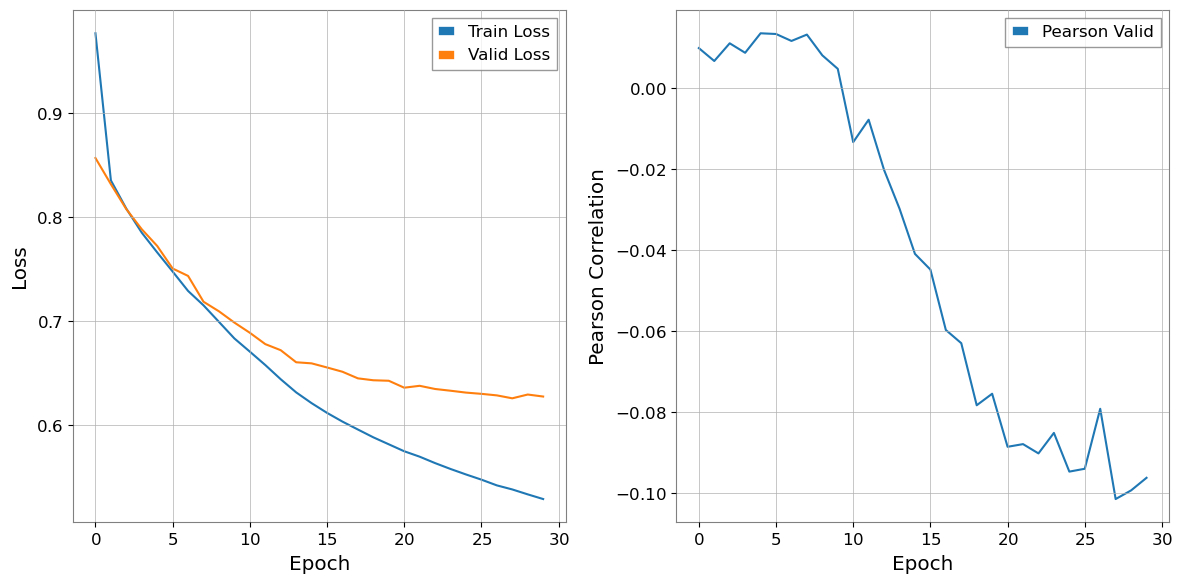

(MCNN(
   (_heads): ModuleList(
     (0-3): 4 x Sequential(
       (0): ConvTranspose1d(1000, 128, kernel_size=(16,), stride=(2,), padding=(7,))
       (1): ELU(alpha=1.0)
       (2): ConvTranspose1d(128, 64, kernel_size=(16,), stride=(2,), padding=(7,))
       (3): ELU(alpha=1.0)
       (4): ConvTranspose1d(64, 32, kernel_size=(16,), stride=(2,), padding=(7,))
       (5): ELU(alpha=1.0)
       (6): ConvTranspose1d(32, 16, kernel_size=(16,), stride=(2,), padding=(7,))
       (7): ELU(alpha=1.0)
       (8): ConvTranspose1d(16, 8, kernel_size=(16,), stride=(2,), padding=(7,))
       (9): ELU(alpha=1.0)
       (10): ConvTranspose1d(8, 4, kernel_size=(16,), stride=(2,), padding=(7,))
       (11): ELU(alpha=1.0)
       (12): ConvTranspose1d(4, 2, kernel_size=(16,), stride=(2,), padding=(7,))
       (13): ELU(alpha=1.0)
       (14): ConvTranspose1d(2, 1, kernel_size=(16,), stride=(2,), padding=(7,))
       (15): ELU(alpha=1.0)
     )
   )
   (linear): Linear(in_features=4, out_features=1, bi

In [31]:
optimizer = optim.Adam(model.parameters())
train(model, optimizer, lr=1e-4, steps=30, batch_size=32)

-0.11281977856297355
-0.01008366059019944
-0.13442909764506233
0.1993871398832261
-0.23404711554190175


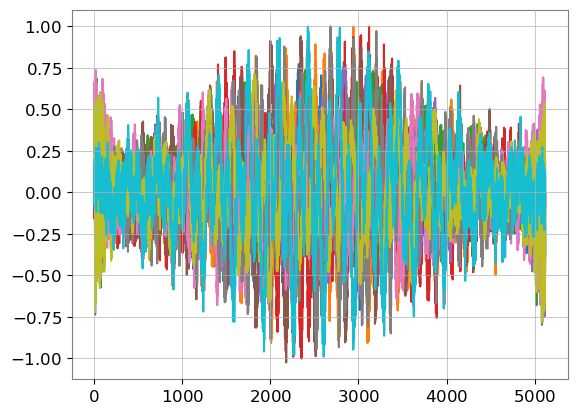

In [33]:
out=model(X_test_tensor.cuda())
for i in range(5):
    generated=out[i].data.cpu().numpy()
    plt.plot(generated)
    real=y_test_tensor[i].data.cpu().numpy()
    plt.plot(real)

    pearson_corr, _ = pearsonr(generated, real)
    print(pearson_corr)

In [ ]:
generated2=out[3].data.cpu().numpy()
plt.plot(generated-generated2)

In [ ]:
tms_real=TimeSeries(df_test_tms.iloc[0][0], dt=1/512)
qplot_test=tms_real.q_transform(qrange=(5,5),frange=(5,15))
spectrogram_test=torch.tensor(qplot_test)
#H, W= spectrogram_test.shape
#spectrogram_test = spectrogram_test.view(1, 1, H, W)

In [ ]:
spectrogram_test.shape

In [ ]:
inputs[0].shape

In [ ]:
outputs=model(inputs)
outputs[0]

In [ ]:
nan_inputs = torch.load('nan_inputs.pt')

In [ ]:
model(nan_inputs)

In [ ]:
torch.save(model.state_dict(), 'mcnn_model.pth')

In [ ]:
model = MCNN(4)
model = model.cuda()
optimizer = optim.Adam(model.parameters())
model(nan_inputs)

In [ ]:
nan_inputs[0:2]

In [ ]:
layers = []
for i, p in enumerate(DEFAULT_LAYERS_PARAMS):
    stride, kernel_size, out_channels, add = p
    if i == 0:
        in_channels = 1000
    else:
        in_channels = DEFAULT_LAYERS_PARAMS[i-1][2]
    padding = (kernel_size - stride)//2
    m = torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size + add, stride=stride, padding=padding)

In [ ]:
x=nan_inputs
b = x.shape[0]
out = [head(x).reshape(-1, 1) for head in self._heads]
out = torch.cat(out, dim=1)
#out = self.linear(out)
#out = self.act_fn(out).reshape(b, -1)

In [ ]:
for inputs, targets in train_loader:
    inputs=inputs.cuda()
    model.eval()
    print(model(inputs))

# Validation

In [ ]:
# a function which transates the two curves to maximise their pearson correlation
def maximise_pearson(curve1, curve2, trans_step=10):
    max_corr=0
    delta_max_corr=0
    max_delta=int(len(curve1)/trans_step)
    for delta in np.arange(0,max_delta, trans_step):
        cv1=curve1[:len(curve1)-delta]
        cv2=curve2[delta:]
        pearson_corr, _ = pearsonr(cv1,cv2)
        if np.abs(pearson_corr)>np.abs(max_corr):
            max_corr=pearson_corr
            delta_max_corr=delta
    cv1=curve1[:len(curve1)-delta_max_corr]
    if max_corr<0:
        cv2=-curve2[delta_max_corr:]
    else:
        cv2=curve2[delta_max_corr:]
    return cv1, cv2

In [ ]:
import scipy.stats

low_freq=5
high_freq=25
correlation_list=[]

for i in range(10):
    tms_real=TimeSeries(df_test_tms.iloc[i][0], dt=1/500)
    qplot_test=tms_real.q_transform(qrange=(5,5),frange=(5,15))
    spectrogram_test=torch.tensor(qplot_test, dtype=torch.float64)
    H, W= spectrogram_test.shape
    spectrogram_test = spectrogram_test.view(1, 1, H, W)
    model.eval()
    with torch.no_grad():
        output = model(spectrogram_test)
    tms_generated=TimeSeries(output[0], dt=1/500)
    #tms_generated=tms_generated/max(np.array(tms_generated))
    
    #tms_real=tms_real[512:9*512]
    #tms_generated=tms_generated[512:9*512]
    
    tms_real, tms_generated=maximise_pearson(tms_real, tms_generated)
    
    q_generated=tms_generated.q_transform(qrange=(5,5),frange=(5,15))
    q_real=tms_real.q_transform(qrange=(5,5),frange=(5,15))
    
    correlation, _ = scipy.stats.pearsonr(tms_real, tms_generated)
    correlation_list.append(abs(correlation))
    
        print('Correlation: '+str(correlation))    
    fig=plt.figure(figsize=(14, 7))
    gs=gridspec.GridSpec(3,1)
    ax1 = plt.subplot(gs[0,0])
    #ax1.plot(np.array(tms_real), label='Original TimeSeries')
    #ax1.plot(np.array(tms_generated), label='Generated Output')
    
    #ax1.plot(tms_real-tms_generated, label='Signal Difference')
    #plt.plot(tms_real, label='Original TimeSeries')
    #plt.plot(tms_generated, label='Generated Output')
    
    vmin = min(np.min(qplot_test), np.min(q_generated))
    vmax = max(np.max(qplot_test), np.max(q_generated))
    #print(vmin)
    #print(vmax)
    
    ax2=plt.subplot(gs[1,0],sharex=ax1)
    im2=ax2.imshow(q_real, aspect='auto', origin='lower', extent=[tms_real.times.value.min(), tms_real.times.value.max(),low_freq,high_freq], cmap='viridis', vmin=0, vmax=15)

    #im2=ax2.imshow(np.transpose(np.array(q_real)), aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=15)

    ax3 = plt.subplot(gs[2,0], sharex=ax1)
    im3=ax3.imshow(q_generated, aspect='auto', origin='lower', extent=[tms_generated.times.value.min(), tms_generated.times.value.max(),low_freq,high_freq], cmap='viridis', vmin=0, vmax=15)
    #im3=ax3.imshow(np.transpose(np.array(q_generated)), aspect='auto', origin='lower', cmap='viridis', vmin=0, vmax=15)

    ax3.set_xlabel('Time (s)')
    
    
    #plt.title("Comparison of Original TimeSeries and Model Generated Output")
    #plt.xlabel("Time")
    #plt.ylabel("Amplitude")
    #plt.legend()
    plt.show()

In [ ]:
np.mean(correlation_list)